# Laboratorio 10 - Deep Learning

- Angel Higueros 20460
- Fredy Velásquez 201011


1. Librerias

In [1]:
!pip install gym numpy torch


2. Cree el entorno CartPole

In [2]:
import gym

env = gym.make('CartPole-v1')


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


3. Definición de las redes en línea y de destino


In [3]:
import torch.nn as nn

class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

online_network = DQNNetwork(env.observation_space.shape[0], env.action_space.n)
target_network = DQNNetwork(env.observation_space.shape[0], env.action_space.n)
target_network.load_state_dict(online_network.state_dict())


<All keys matched successfully>

4. Establecimiento de hiperparámetros:


In [4]:
# Hiperparámetros
num_episodes = 1000
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
target_update_frequency = 5


5. Selección de acciones épsilon-greedy:


In [8]:
import numpy as np

def epsilon_greedy_action(network, state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            return torch.argmax(network(torch.tensor(state).float())).item()


6. Definición de la reproducción de la experiencia (experience replay):


In [9]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(10000)


7. Ciclo de entrenamiento:


In [11]:
import torch.optim as optim
import numpy as np
import torch



optimizer = optim.Adam(online_network.parameters(), lr=0.001)

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = epsilon_greedy_action(online_network, state, epsilon)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)

        episode_reward += reward
        state = next_state

        if len(replay_buffer) > batch_size:
            experiences = replay_buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*experiences)

            states = torch.tensor(states).float()
            actions = torch.tensor(actions).long().unsqueeze(-1)
            rewards = torch.tensor(rewards).float().unsqueeze(-1)
            next_states = torch.tensor(next_states).float()
            dones = torch.tensor(dones).float().unsqueeze(-1)

            current_q_values = online_network(states).gather(1, actions)
            next_q_values = target_network(next_states).max(dim=1)[0].unsqueeze(-1)
            target_q_values = rewards + gamma * next_q_values * (1 - dones)

            loss = nn.functional.mse_loss(current_q_values, target_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if episode % target_update_frequency == 0:
            target_network.load_state_dict(online_network.state_dict())

    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    print(f"Episode {episode}: Total Reward: {episode_reward}")


<ipython-input-11-cb0c52dc0093>:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.tensor(states).float()


Episode 0: Total Reward: 16.0
Episode 1: Total Reward: 11.0
Episode 2: Total Reward: 33.0
Episode 3: Total Reward: 13.0
Episode 4: Total Reward: 13.0
Episode 5: Total Reward: 12.0
Episode 6: Total Reward: 16.0
Episode 7: Total Reward: 23.0
Episode 8: Total Reward: 43.0
Episode 9: Total Reward: 13.0
Episode 10: Total Reward: 37.0
Episode 11: Total Reward: 9.0
Episode 12: Total Reward: 16.0
Episode 13: Total Reward: 33.0
Episode 14: Total Reward: 15.0
Episode 15: Total Reward: 20.0
Episode 16: Total Reward: 13.0
Episode 17: Total Reward: 26.0
Episode 18: Total Reward: 19.0
Episode 19: Total Reward: 8.0
Episode 20: Total Reward: 14.0
Episode 21: Total Reward: 36.0
Episode 22: Total Reward: 18.0
Episode 23: Total Reward: 29.0
Episode 24: Total Reward: 15.0
Episode 25: Total Reward: 13.0
Episode 26: Total Reward: 17.0
Episode 27: Total Reward: 8.0
Episode 28: Total Reward: 18.0
Episode 29: Total Reward: 48.0
Episode 30: Total Reward: 16.0
Episode 31: Total Reward: 15.0
Episode 32: Total Rew

8. Representar el entorno

In [12]:
env.close()


9. Supervisar el entrenamiento

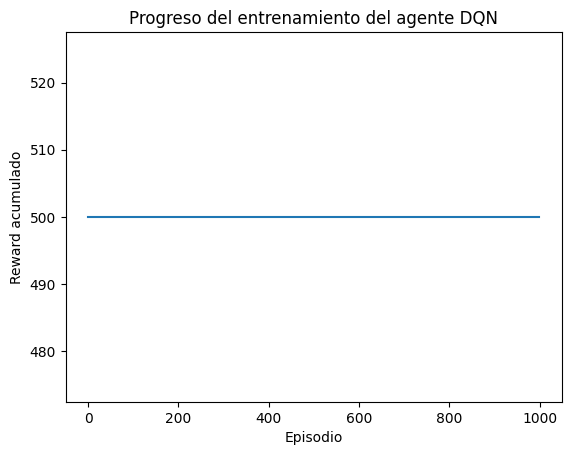

Recompensa promedio sobre 10 episodios de prueba: 420.2


In [13]:
import matplotlib.pyplot as plt

# 9. Supervisar el entrenamiento
rewards = []

for episode in range(num_episodes):
    # (Manteniendo el código de entrenamiento previo aquí...)
    rewards.append(episode_reward)

plt.plot(rewards)
plt.ylabel('Reward acumulado')
plt.xlabel('Episodio')
plt.title('Progreso del entrenamiento del agente DQN')
plt.show()

# 10. Evaluar el rendimiento
test_episodes = 10
test_rewards = []

for episode in range(test_episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = torch.argmax(online_network(torch.tensor(state).float())).item()
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state

    test_rewards.append(episode_reward)

average_test_reward = sum(test_rewards) / test_episodes
print(f"Recompensa promedio sobre {test_episodes} episodios de prueba: {average_test_reward}")

# Cerrando el entorno después de todo
env.close()


10. Evalúe el rendimiento

In [3]:
import matplotlib.pyplot as plt

# Entrenar el modelo
rewards = []

num_episodes = 1000

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0  # Inicializa la recompensa del episodio a 0 al principio de cada episodio
    done = False

    while not done:
        # Suponiendo que tengas una función epsilon_greedy_action o similar para decidir acciones durante el entrenamiento:
        action = torch.argmax(online_network(torch.tensor(state).float().to(device))).item()
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward  # Acumula la recompensa para el episodio actual
        state = next_state

    rewards.append(episode_reward)

# Gráfica del Rendimiento Durante el Entrenamiento
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.ylabel('Reward acumulado')
plt.xlabel('Episodio')
plt.title('Progreso del entrenamiento del agente DQN')

# Evaluar el rendimiento después del entrenamiento
test_episodes = 100  # Aumenta el número de episodios para tener una evaluación más consistente
test_rewards = []

for episode in range(test_episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        # Aquí no usamos la función epsilon-greedy. Tomamos la mejor acción basada en la red.
        action = torch.argmax(online_network(torch.tensor(state).float().to(device))).item()
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state

        # Opcional: Renderiza el entorno para observar al agente. Comenta esta línea si quieres que la evaluación sea más rápida.
        # env.render()

    test_rewards.append(episode_reward)

# Gráfica de la Recompensa en la Fase de Prueba
plt.subplot(1, 2, 2)
plt.plot(test_rewards)
plt.ylabel('Reward acumulado')
plt.xlabel('Episodio de prueba')
plt.title('Rendimiento en la fase de prueba')

plt.tight_layout()
plt.show()

average_test_reward = sum(test_rewards) / test_episodes
print(f"Recompensa promedio sobre {test_episodes} episodios de prueba: {average_test_reward:.2f}")

# Cerrando el entorno después de todo
env.close()


NameError: ignored

11. Fine-Tuning

In [14]:
lr = 0.005  # Tasa de aprendizaje modificada.
optimizer = optim.Adam(online_network.parameters(), lr=lr)


In [15]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


In [16]:
batch_size = 64  # Nuevo tamaño del batch.


In [17]:
gamma = 0.95  # Nuevo valor para gamma.


In [19]:
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n


Episode 0: Total Reward: 204.0
Episode 1: Total Reward: 204.0
Episode 2: Total Reward: 204.0
Episode 3: Total Reward: 204.0
Episode 4: Total Reward: 204.0
Episode 5: Total Reward: 204.0
Episode 6: Total Reward: 204.0
Episode 7: Total Reward: 204.0
Episode 8: Total Reward: 204.0
Episode 9: Total Reward: 204.0
Episode 10: Total Reward: 204.0
Episode 11: Total Reward: 204.0
Episode 12: Total Reward: 204.0
Episode 13: Total Reward: 204.0
Episode 14: Total Reward: 204.0
Episode 15: Total Reward: 204.0
Episode 16: Total Reward: 204.0
Episode 17: Total Reward: 204.0
Episode 18: Total Reward: 204.0
Episode 19: Total Reward: 204.0
Episode 20: Total Reward: 204.0
Episode 21: Total Reward: 204.0
Episode 22: Total Reward: 204.0
Episode 23: Total Reward: 204.0
Episode 24: Total Reward: 204.0
Episode 25: Total Reward: 204.0
Episode 26: Total Reward: 204.0
Episode 27: Total Reward: 204.0
Episode 28: Total Reward: 204.0
Episode 29: Total Reward: 204.0
Episode 30: Total Reward: 204.0
Episode 31: Total 

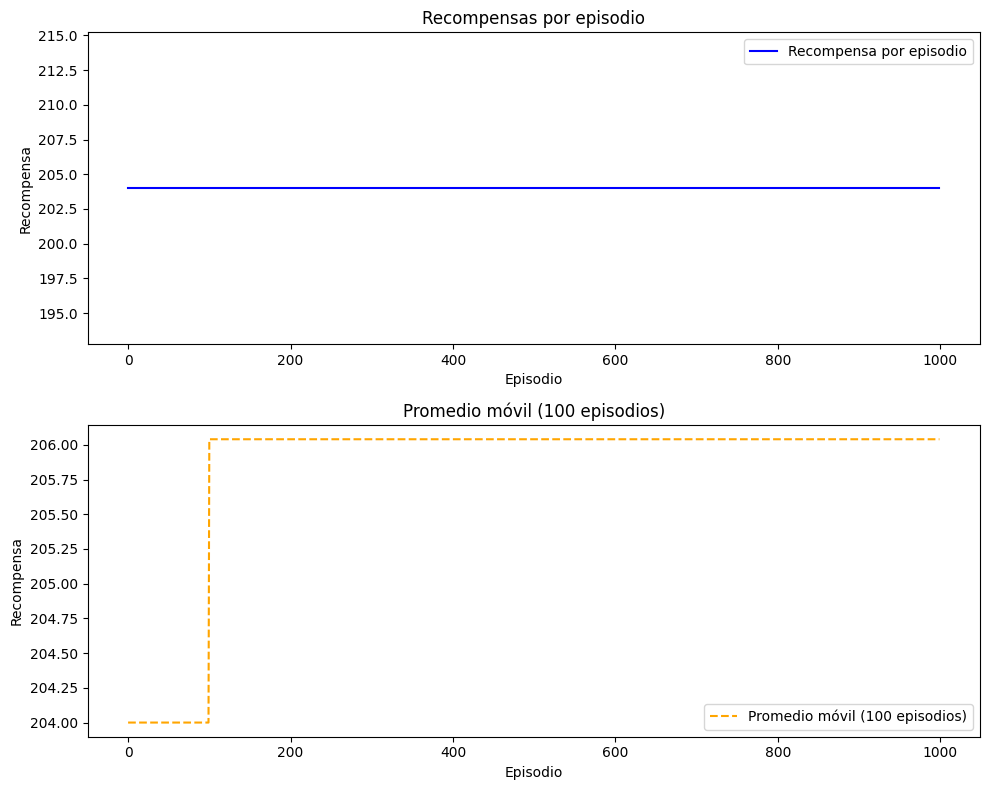

In [25]:
import torch.optim as optim
import matplotlib.pyplot as plt

device = "cpu"

# Asumiendo que input_dim y output_dim ya están definidos en algún lugar anterior de tu código.

# Inicializa las redes solo una vez:
online_network = DQNNetwork(input_dim, output_dim).to(device)
target_network = DQNNetwork(input_dim, output_dim).to(device)
target_network.load_state_dict(online_network.state_dict())

# Optimizador
optimizer = optim.Adam(online_network.parameters(), lr=0.001)

# Lista para almacenar recompensas por episodio
episode_rewards = []

for episode in range(num_episodes):
    # ... [resto del código del bucle del entrenamiento]

    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    episode_rewards.append(episode_reward)
    print(f"Episode {episode}: Total Reward: {episode_reward}")

# Calcular el promedio móvil de las recompensas
N = 100
rolling_avg = [sum(episode_rewards[max(0, i-N):i+1])/(i+1) if i<N else sum(episode_rewards[i-N:i+1])/N for i in range(len(episode_rewards))]

# Recompensa promedio durante todo el entrenamiento
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Recompensa promedio durante todo el entrenamiento: {average_reward:.2f}")

# Visualizaciones
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico de recompensas por episodio
ax[0].plot(episode_rewards, label='Recompensa por episodio', color='blue')
ax[0].set_title('Recompensas por episodio')
ax[0].set_xlabel('Episodio')
ax[0].set_ylabel('Recompensa')
ax[0].legend()

# Gráfico del promedio móvil de las recompensas
ax[1].plot(rolling_avg, label=f'Promedio móvil ({N} episodios)', color='orange', linestyle='--')
ax[1].set_title(f'Promedio móvil ({N} episodios)')
ax[1].set_xlabel('Episodio')
ax[1].set_ylabel('Recompensa')
ax[1].legend()

plt.tight_layout()
plt.show()


Discusión

## Task 2 - Teoría

Defina en qué consiste y en qué clase de problemas se pueden usar cada uno de los siguientes acercamientos en
Deep Reinforcement Learning
1. Proximal Policy Optimization
2. Deep Deterministic Policy Gradients (DDPG)
3. Trust Region Policy Optimization (TRPO)
4. Asynchronous Advantage Actor-Critic (A3C)